In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import copy

import sys
sys.path.append("Fall 2024")

import kmax as kx
import utility as util
from hierarchy import *

# Continuous Edge Weights - Transition Probabilities

## Function Definitions

In [2]:
def get_section(Z_val):
    if Z_val <= 0:
        return 0
    else:
        section_bounds = np.linspace(0.0, 1.0, num_sections)
        return int(Z_val // (1 / num_sections))

## Simulation

In [3]:
num_samples = 1000
lam = 0.7
offspring_dist = lambda: np.random.poisson(lam)
edge_dist = lambda: np.random.uniform(0,1)

In [4]:
# Setup transition count matrix
num_sections = 4
transition_counts = np.zeros(shape=(num_sections+1,num_sections+1),
                             dtype=int)

In [5]:
for _ in range(num_samples):
    # Generate tree
    tree = nx.Graph(GWBP(dist=offspring_dist, MAXLEVEL=10))
    for u,v in tree.edges():
        tree[u][v]['weight'] = edge_dist()

    if tree.number_of_nodes() == 1:
        transition_counts[0][0] += 1
        continue
    
    # Get Z values, children
    tups = util.path_cover(tree, root=0, return_tuples=True)
    Z = {v:tup[1] for v,tup in tups}
    v1 = {v:tup[2] for v,tup in tups}
    v2 = {v:tup[3] for v,tup in tups}

    current_node = v1[0] # first max child of root 0
    while True:
        current_section = get_section(Z[current_node]) + 1
        if v1[current_node] is not None:
            v1_section = get_section(Z[v1[current_node]]) + 1
            transition_counts[current_section][v1_section] += 1
            if Z[v1[current_node]] < 0:
                break
            else:
                current_node = v1[current_node]
        else:
            transition_counts[current_section][0] += 1
            break

In [6]:
transition_counts

array([[492,   0,   0,   0,   0],
       [ 95,  34,  31,  37,  36],
       [148,  31,  32,  23,  27],
       [118,  39,  35,  26,  23],
       [130,  21,  32,  24,  36]])

In [7]:
my_shape = transition_counts.shape
transition_probs = np.ndarray(shape=my_shape, dtype=float)
for i in range(my_shape[0]):
    for j in range(my_shape[1]):
        transition_probs[i][j] = transition_counts[i][j] / num_samples

### TODO - adjust probabilities so that `transition_probs` sums to 1

In [8]:
transition_probs

array([[0.492, 0.   , 0.   , 0.   , 0.   ],
       [0.095, 0.034, 0.031, 0.037, 0.036],
       [0.148, 0.031, 0.032, 0.023, 0.027],
       [0.118, 0.039, 0.035, 0.026, 0.023],
       [0.13 , 0.021, 0.032, 0.024, 0.036]])

In [9]:
sum(transition_probs)

array([0.983, 0.125, 0.13 , 0.11 , 0.122])

TypeError: bar3d() missing 5 required positional arguments: 'y', 'z', 'dx', 'dy', and 'dz'

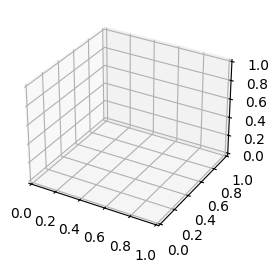

In [10]:
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(transition_probs)